In [2]:
pip install darts


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from darts.models import LightGBMModel

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
from calendar import month_name as mn
import os
import seaborn as sns
import numpy as np




import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

In [4]:
merged_df=pd.read_csv('monthly_NPS_5ch_Touchpoints_adjusted_complete')
merged_df.tail()

,date_flight_local,year,month,cabin,haul,NPS,promoters_weight,detractors_weight,monthly_weight,NPS_weighted,...,inm_400_issues_response_not_nulls,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_sum,img_310_ease_contact_phone_std,img_310_ease_contact_phone_mean,img_310_ease_contact_phone_not_nulls,img_310_ease_contact_phone_satisfaction,load_factor,otp15_landing,otp15_takeoff
284,2023-06-30,2023,6,Premium Economy,LH,24.352332,114.93264,60.55176,223.30872,24.352332,...,117,12.820513,929.0,3.485695,6.363014,146,50.000000,90.055018,84.727273,85.090909
285,2023-07-31,2023,7,Premium Economy,LH,33.268482,141.03655,59.28316,245.73826,33.268482,...,99,7.070707,774.0,3.478570,6.672414,116,56.896552,88.964859,84.216460,87.204059
286,2023-08-31,2023,8,Premium Economy,LH,40.034072,155.25744,53.34264,254.57016,40.034072,...,103,14.563107,938.0,3.438053,6.468966,145,53.793103,83.972265,88.846983,90.140086
287,2023-09-30,2023,9,Premium Economy,LH,22.379603,132.81190,74.68370,259.73740,22.379603,...,144,8.333333,1045.0,3.580645,5.971429,175,43.428571,88.909513,83.827644,88.696139
288,2023-10-31,2023,10,Premium Economy,LH,38.619677,140.21766,51.14219,230.64789,38.619677,...,114,11.403509,1077.0,3.451915,6.567073,164,54.268293,86.218926,80.401737,84.636265


In [5]:
grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
grouped = merged_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in grouped:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    grouped_dfs[group_df_name] = group_df

In [6]:
for key in grouped_dfs.keys():
    df = grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2022, 2023])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    grouped_dfs[key] = df

In [7]:
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.head()

,date_flight_local,year,month,cabin,haul,NPS,promoters_weight,detractors_weight,monthly_weight,NPS_weighted,...,inm_400_issues_response_not_nulls,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_sum,img_310_ease_contact_phone_std,img_310_ease_contact_phone_mean,img_310_ease_contact_phone_not_nulls,img_310_ease_contact_phone_satisfaction,load_factor,otp15_landing,otp15_takeoff
0,2021-01-31,2019,1,Business,LH,42.222786,121.665838,25.560050,195.789983,42.222786,...,40,20.900000,2212.0,2.485108,7.135484,310,64.948387,76.167697,80.512821,87.692308
1,2021-02-28,2019,2,Business,LH,40.075400,113.669117,26.158165,186.436376,40.075400,...,38,24.452632,2130.0,2.667397,7.029703,303,67.175578,78.736435,80.543319,89.500734
2,2021-03-31,2019,3,Business,LH,39.648252,135.857876,30.774436,225.929396,39.648252,...,24,32.566667,1615.0,2.593937,6.843220,236,61.400000,81.877567,80.798479,85.868188
3,2021-04-30,2019,4,Business,LH,31.650138,128.308856,41.757320,224.730304,31.650138,...,26,26.476923,1650.0,2.409821,7.021277,235,63.314894,80.872556,76.674938,85.669975
4,2021-05-31,2019,5,Business,LH,46.491257,164.737385,30.536686,251.525861,46.491257,...,35,29.114286,1595.0,2.774046,6.618257,241,58.702905,84.401310,81.844548,86.948956


# Puntuality touchpoint

In [8]:
def fill_missing_dates(df, freq):
    # Create a date range covering the expected time period
    start_date = df['date_flight_local'].min()
    end_date = df['date_flight_local'].max()
    expected_dates = pd.date_range(start_date, end_date, freq=freq)

    # Reindex the DataFrame with the expected dates
    df = df.set_index('date_flight_local').reindex(expected_dates)

    # Use forward fill to fill missing values in other columns
    df.fillna(method='ffill', inplace=True)

    # Reset the index to have 'date_flight_local' as a regular column
    df.reset_index(inplace=True)
    
    # Rename the index column back to 'date_flight_local'
    df.rename(columns={'index': 'date_flight_local'}, inplace=True)

    return df

# Apply the fill_missing_dates function to each DataFrame in grouped_dfs.values()
for key, df in grouped_dfs.items():
    grouped_dfs[key] = fill_missing_dates(df,freq='M')

In [9]:
pip install miceforest


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
original_features=[col for col in merged_df.columns if col.endswith('_satisfaction')] + ['load_factor'] + [col for col in merged_df.columns if col.startswith('otp15_takeoff')]

In [11]:
import miceforest as mf

for df_name, df in grouped_dfs.items():
    # Create kernel. 
    kds = mf.ImputationKernel(
      df[original_features],  # Use the columns you're using for imputation
      save_all_iterations=True,
      random_state=100
    )

    # Run the MICE algorithm for 2 iterations
    kds.mice(10)

    # Create a copy of the original dataframe with all columns
    filled_df = df.copy()

    # Fill in the NaN values using the completed data from MICE
    filled_df[original_features] = kds.complete_data()

    # Update the grouped_dfs dictionary with the filled dataframe
    grouped_dfs[df_name] = filled_df

In [12]:
grouped_dfs[key]

,date_flight_local,year,month,cabin,haul,NPS,promoters_weight,detractors_weight,monthly_weight,NPS_weighted,...,inm_400_issues_response_not_nulls,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_sum,img_310_ease_contact_phone_std,img_310_ease_contact_phone_mean,img_310_ease_contact_phone_not_nulls,img_310_ease_contact_phone_satisfaction,load_factor,otp15_landing,otp15_takeoff
0,2021-01-31,2019,1,Premium Economy,LH,30.335295,106.616960,38.243040,221.346080,30.335295,...,14,20.328571,877.0,2.845192,6.264286,140,51.528571,70.134017,80.512821,87.692308
1,2021-02-28,2019,2,Premium Economy,LH,39.090213,111.387960,31.140720,202.414680,39.090213,...,17,28.311765,945.0,2.425792,7.052239,134,59.353731,69.771371,80.543319,89.500734
2,2021-03-31,2019,3,Premium Economy,LH,49.804955,135.229840,25.159040,218.569160,49.804955,...,16,30.150000,782.0,2.516453,6.741379,116,54.065517,77.155172,80.798479,85.868188
3,2021-04-30,2019,4,Premium Economy,LH,27.689518,106.610400,48.601800,205.381800,27.689518,...,12,-1.100000,635.0,3.006554,6.614583,96,55.933333,79.301373,76.674938,85.669975
4,2021-05-31,2019,5,Premium Economy,LH,36.057265,142.737240,48.050160,258.622920,36.057265,...,24,7.233333,957.0,2.868410,6.600000,145,57.686207,79.546730,81.844548,86.948956
5,2021-06-30,2019,6,Premium Economy,LH,36.038303,152.531874,52.567482,273.178554,36.038303,...,42,17.947619,1690.0,2.853698,6.814516,248,62.519355,85.101198,73.364486,83.119159
6,2021-07-31,2019,7,Premium Economy,LH,38.492862,186.337710,55.742050,334.452300,38.492862,...,27,17.418519,1084.0,2.797563,6.530120,166,55.280723,86.084759,77.350427,84.188034
7,2021-08-31,2019,8,Premium Economy,LH,41.426375,162.847080,45.014640,280.679520,41.426375,...,24,11.400000,1091.0,2.532018,6.861635,159,62.301258,84.394869,81.143162,87.713675
8,2021-09-30,2019,9,Premium Economy,LH,46.435984,196.756020,48.824642,314.809632,46.435984,...,33,26.172727,2384.0,2.546609,6.991202,341,64.352199,83.757036,80.696745,87.892633
9,2021-10-31,2019,10,Premium Economy,LH,40.339812,153.419568,46.692912,260.980026,40.339812,...,31,21.480645,1579.0,2.771431,6.806034,232,60.962069,84.370780,78.306265,90.893271


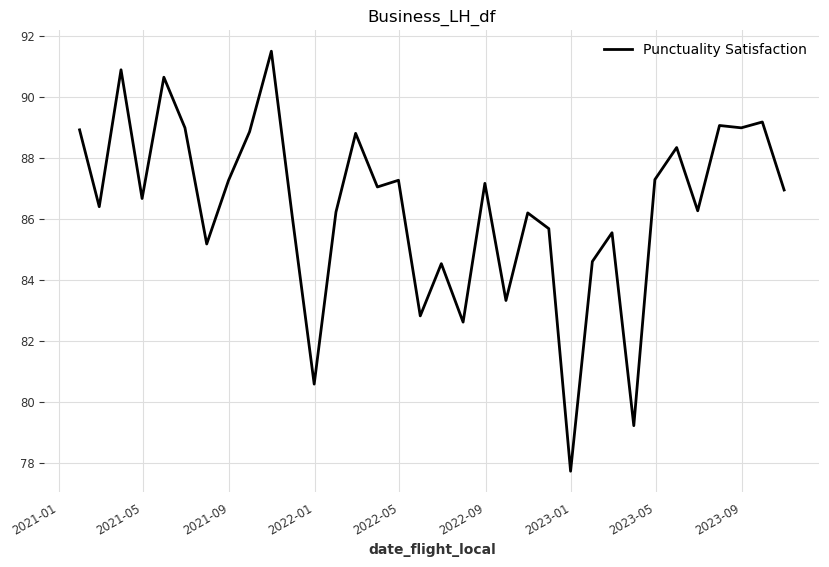

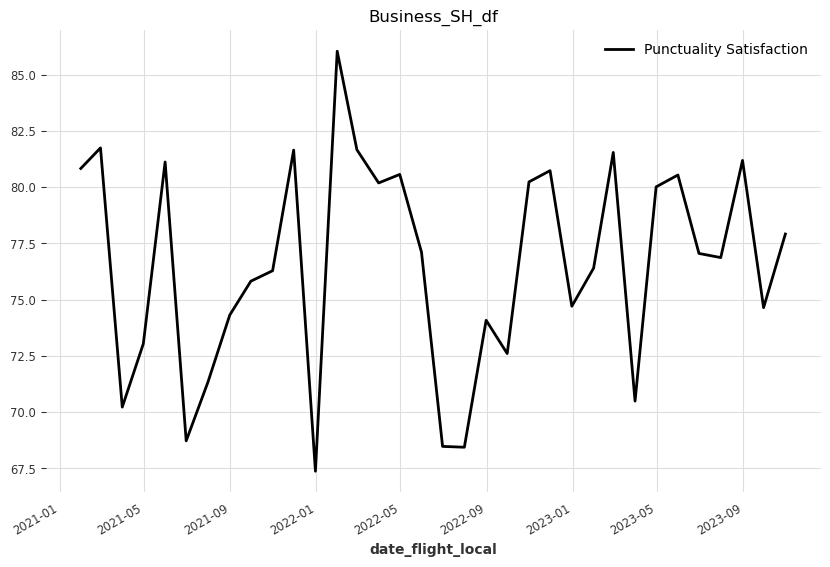

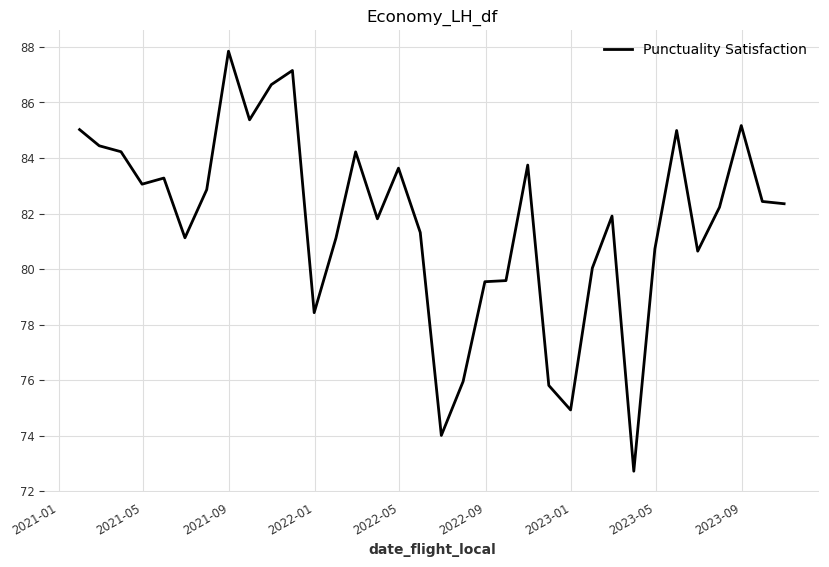

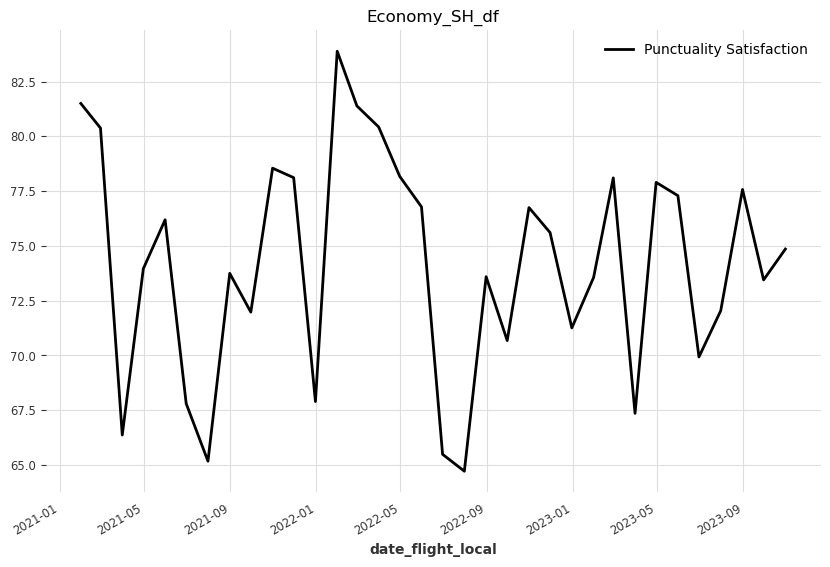

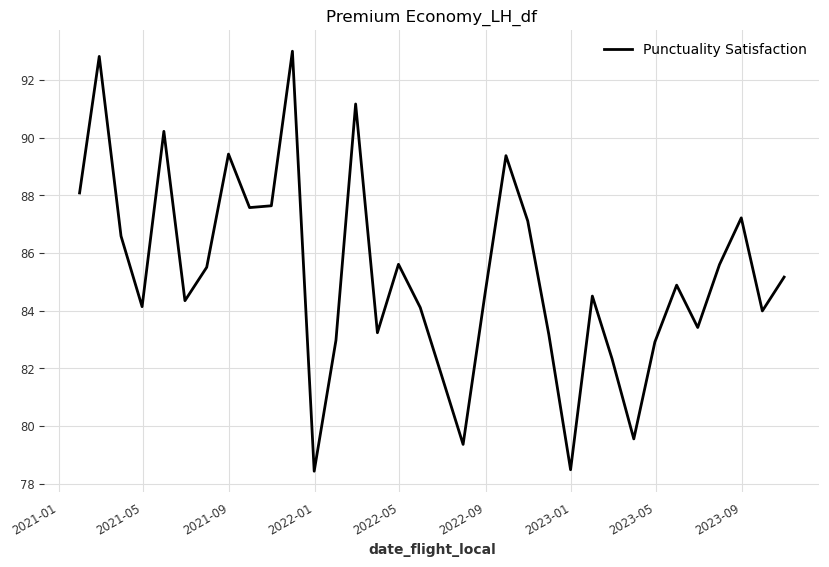

In [13]:
punct_ts={}
for key,df in grouped_dfs.items():
    grouped_dfs[key]['date_flight_local']=pd.to_datetime(grouped_dfs[key]['date_flight_local'])
    punct_ts[key]=TimeSeries.from_dataframe(df, time_col='date_flight_local',value_cols=['pun_100_punctuality_satisfaction'], freq='M')
    plt.figure(figsize=(10, 6))
    punct_ts[key].plot(label='Punctuality Satisfaction')  # Use the correct nps_ts for each dataframe
    plt.title(f"{key}")
    plt.show()

## Lets take Economy SH

In [14]:
df= grouped_dfs['Economy_SH_df']

In [15]:
ts=punct_ts['Economy_SH_df']

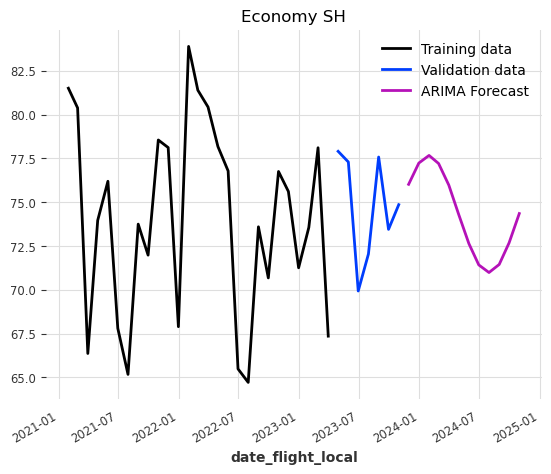

In [18]:
from darts import TimeSeries
from darts.models import ARIMA
from darts.models import AutoARIMA
from darts.utils.timeseries_generation import holidays_timeseries

# Assuming you have a Darts TimeSeries object named 'ts'
# Let's first split it into training and validation data
train_size = int(len(ts) * 0.8)  # 80% for training
train, val = ts[:train_size], ts[train_size:]

future_cov = datetime_attribute_timeseries(ts, "month", cyclic=True, add_length=20)

model = AutoARIMA(start_p=8, max_p=12, start_q=1)
model.fit(ts, future_covariates=future_cov)
pred = model.predict(12, future_covariates=future_cov)

# You can also plot the forecast and compare it with the validation data
train.plot(label='Training data')
val.plot(label='Validation data')
pred.plot(label='ARIMA Forecast')
plt.title("Economy SH")
plt.legend()
plt.show()